# Timing for Basic Digital Circuits

In this notebook, we will show how to view the timing diagram for the simple scalar function digital circuit that we have simulated.  Before running the notebook, you should complete one of the two simulations:
*  [scalar function simulation](https://sdrangan.github.io/hwdesign/units/basic_logic/simulation.md): Simulates a simple function multiplying two numbers `a` and `b`
*  [polynomial simulation](https://sdrangan.github.io/hwdesign/units/basic_logic/poly.md): Simulates a quadratic function of a single input `x`.  This function takes a two clock cycles to complete.

After running the simulation, there should be a `sim` directory in `hwdesign/demos/basic_logic`.

Set the following variable depending on what simulation you ran

In [136]:
sim_type = 'poly_fun'  # Set to 'simp_fun' or 'poly_fun'

## Parsing the VCD File

Running the simulation, will create a [**Value Change Dump**](https://en.wikipedia.org/wiki/Value_change_dump)  or **VCD** file with the values for all the signals in the device under test and the testbench.  To read this file, we import the `vcdvcd` package and read the VCD file with the following code.  

In [137]:
from vcdvcd import VCDVCD
import matplotlib.pyplot as plt

In [138]:
# Parse the VCD file
import os
fn = os.path.join(os.getcwd(), "sim", "dump.vcd")
vcd = VCDVCD(fn, signals=None, store_tvs=True)

# Print the signals
for s in vcd.signals:
    print(s)

tb_poly_fun.clk
tb_poly_fun.rst
tb_poly_fun.x_in[15:0]
tb_poly_fun.y_out[15:0]
tb_poly_fun.dut.clk
tb_poly_fun.dut.rst
tb_poly_fun.dut.x[15:0]
tb_poly_fun.dut.y[15:0]
tb_poly_fun.dut.x_s0[15:0]
tb_poly_fun.dut.x_sq_s1[15:0]
tb_poly_fun.dut.w1_x_s1[15:0]
tb_poly_fun.Block32_5.x[15:0]
tb_poly_fun.Block32_5.y_exp[15:0]
tb_poly_fun.Block32_5.Block59_6.i[31:0]
tb_poly_fun.Block32_5.Block78_7.j[31:0]


We see that the simulation generated a number of signals in both the testbench and the device under test.  Most of these are duplicates, so we will just look at the signals corresponding to the clock, inputs and outputs at the top level.  To parse these signals from the VCD file, I have created a simple utility class, `VCDParser` in `xilinxutils`.  The following code instantiates the parser and then extract the top level signals.

In [139]:
import importlib
import xilinxutils
import xilinxutils.vcd
import xilinxutils.timing
importlib.reload(xilinxutils)
importlib.reload(xilinxutils.vcd)
importlib.reload(xilinxutils.timing)
from xilinxutils.vcd import VcdParser
from xilinxutils.timing import TimingDiagram

In [140]:
# Create a parsing class
vp = VcdParser(vcd)

# Get the names of the signals to parse
if sim_type == 'simp_fun':
    prefix = 'tb_simp_fun'
    signals = [
        'clk',
        'a_in',
        'b_in',
        'dut.a_reg',
        'dut.b_reg',
        'c_out'
    ]
    dtype = 'uint'
elif sim_type == 'poly_fun':
    prefix = 'tb_poly_fun'
    signals = [
        'clk',
        'x_in',
        'dut.x_s0',
        'dut.x_sq_s1',
        'dut.w1_x_s1',
        'y_out',
    ]
    dtype = 'int'
else:
    raise ValueError(f"Unknown sim_type: {sim_type}")   

# For each signal, find it in the VCD and add it to the parser
for sig in signals:
    name = f'{prefix}.{sig}'
    found = False
    for s in vcd.signals:
        if name in s:
            vp.add_signal(s, short_name=sig, 
                          numeric_type=dtype,
                          numeric_fmt_str='%d')
            print(f"Added signal: {s}")
            found = True
            break
    if not found:
        raise ValueError(f"Signal not found: {name}")



Added signal: tb_poly_fun.clk
Added signal: tb_poly_fun.x_in[15:0]
Added signal: tb_poly_fun.dut.x_s0[15:0]
Added signal: tb_poly_fun.dut.x_sq_s1[15:0]
Added signal: tb_poly_fun.dut.w1_x_s1[15:0]
Added signal: tb_poly_fun.y_out[15:0]


## Creating a Timing Diagram

We can also visualize the signals in a timing diagram.  For this purpose, I have added a `TimingDiagram` class that can be used as follows.

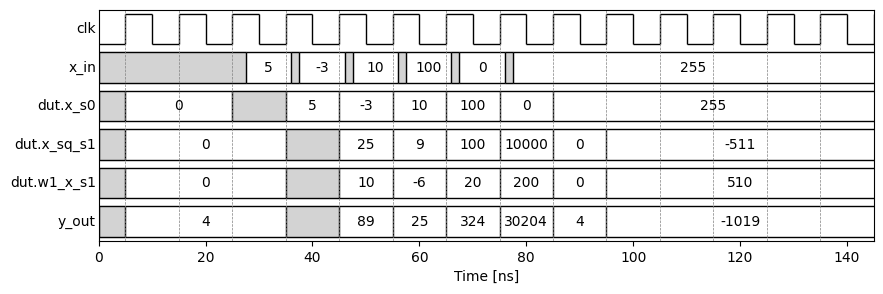

In [141]:
# Get the timing signals
sig_list = vp.get_td_signals()

# Create the timing diagram
td = TimingDiagram()
td.add_signals(sig_list)
trange = None
ax = td.plot_signals(add_clk_grid=True, trange=trange, text_mode='always')
_ = ax.set_xlabel('Time [ns]')


It is useful to highlight the items for a given input and output so you can see how the internal signals propagate.

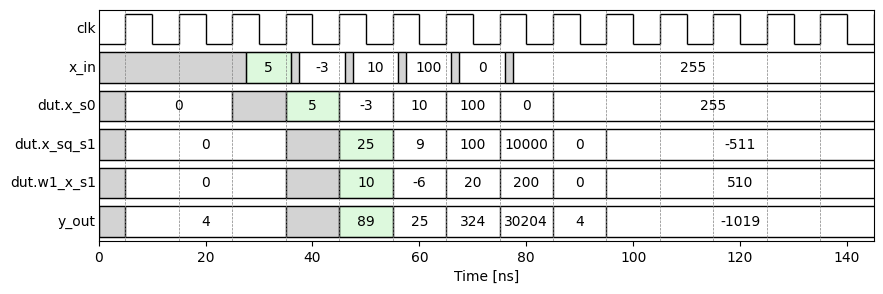

In [142]:
# Get the timing signals
sig_list = vp.get_td_signals()

# Create the timing diagram
td = TimingDiagram()
td.add_signals(sig_list)
trange = None
ax = td.plot_signals(add_clk_grid=True, trange=trange, text_mode='always')
_ = ax.set_xlabel('Time [ns]')

# Highlight signals belong to each pipeline stage
import matplotlib.patches as patches

# Parameters.  We hard code these for simplicity, although they could be extracted from the VCD
clk_period = 10  # Clock period in ns

input_dly = 0.25 # Input propagation delay in clock cycles
input_wid = 0.85 # Input pulse width in clock cycles

# Signals to highlight
if sim_type == 'simp_fun':
    tinit = 35 # Time of the first input
    sigs = ['a_in', 'b_in', 'dut.a_reg', 'dut.b_reg', 'c_out']
    dlys = [input_dly-1, input_dly-1, 0, 0, 0 ]  # Delay in clock cycles
    wid = [input_wid, input_wid, 1, 1, 1]  # Width in clock cycles

else:  # sim_type == 'poly_fun'
    tinit = 35 # Time of the first input
    sigs = ['x_in', 'dut.x_s0', 'dut.x_sq_s1', 'dut.w1_x_s1', 'y_out']
    dlys = [input_dly-1, 0, 1, 1, 1 ]  # Delay in clock cycles
    wid = [input_wid, 1, 1, 1, 1]  # Width in clock cycles


for sig, dly, w in zip(sigs, dlys, wid):
    t0 = tinit + dly * clk_period
    t1 = t0 + w * clk_period
    color = 'lightgreen' 
    ytop = td.ytop[sig]
    ybot = td.ybot[sig]

    # Draw a shaded region for the beat 
    rect = patches.Rectangle(xy=(t0, ybot), width=(t1 - t0), height=(ytop - ybot),
                    linewidth=1, 
                    edgecolor='black', 
                    facecolor=color, 
                    alpha=0.3)  # alpha controls shading

    ax.add_patch(rect)
